Here we want to experiment with getting a similar random forest model running. Then we need to develop a pipeline for a feature selection process. Then finally we need to have a process set up to try different machine learning architectures for tabular datasets (and hyperparameter tuning included).

In [1]:
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

/Users/hamishcampbell/opt/miniconda3/envs/geospatial/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import wandb

In [10]:
# load in the dataset
df = pd.read_csv('depth_dataset.csv', index_col='system:index')
df

,AV_STK_100,AV_STK_150,AV_STK_30,Blue,CROPTYPE,Elevation,Green,Landcover,Landcover_conf,MRRTF,...,Sen1_Index3,Sen1_VH,Sen1_VV,Soilscapes,Soiltype,TWI,d2_River,d2_Watercourse,date,depth
system:index,,,,,,,,,,,,,,,,,,,,,
0,9.260000,5.490000,10.420000,653.666667,1,2.65525,902.000000,3,94,4,...,6.967378,-21.588568,-14.621190,8,46,15.141784,818.413086,30.000000,1980,0
1,9.260000,5.490000,10.420000,582.500000,16,2.31175,801.000000,3,98,4,...,6.516706,-19.182083,-12.665377,8,46,12.653238,197.989899,36.055511,1980,0
2,66.599998,36.169998,33.459999,525.000000,16,1.16625,682.000000,21,54,4,...,7.014743,-20.876295,-13.861552,0,4,13.789957,509.215088,20.000000,1985,41
3,66.599998,36.169998,33.459999,543.333333,2,1.28775,743.666667,3,97,3,...,7.555333,-20.863428,-13.308095,0,4,13.953518,660.984131,60.827629,1980,55
4,66.599998,36.169998,33.459999,548.333333,2,1.70425,741.333333,3,89,3,...,7.973936,-19.612972,-11.639036,0,4,14.691748,652.533508,0.000000,1985,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1282,81.459999,45.310001,37.349998,567.642857,24,-1.51500,833.607143,3,42,0,...,8.664783,-20.696605,-12.031822,0,3,11.049838,585.234985,22.360680,2022,0
1283,81.459999,45.310001,37.349998,383.066667,24,-1.56250,532.833333,8,34,2,...,10.639980,-18.096999,-7.457020,0,3,12.834105,143.178223,106.301460,2022,40
1284,81.459999,45.310001,37.349998,317.533333,24,-1.69000,398.433333,3,42,0,...,8.255005,-21.953403,-13.698399,0,3,14.961255,502.195160,108.166542,2022,0


In [11]:
# get the feature names from the column headings 
feature_names = [i for i in df.columns]
feature_names.remove('depth')

In [12]:
# set aside 30% of the new data for testing (ONLY USE NEW DATA since this is aim of model) - ~10% of all data
df_newData = df.loc[df['date'] > 2018]
splits_test = TrainTestSplitter(test_size=0.3, random_state=10, shuffle=True)(df_newData)
test_df = df_newData.iloc[splits_test[1],:]

# some models need explicit datasets
x_test = test_df.drop('depth', axis=1)
y_test = test_df['depth']

In [13]:
test_df

,AV_STK_100,AV_STK_150,AV_STK_30,Blue,CROPTYPE,Elevation,Green,Landcover,Landcover_conf,MRRTF,...,Sen1_Index3,Sen1_VH,Sen1_VV,Soilscapes,Soiltype,TWI,d2_River,d2_Watercourse,date,depth
system:index,,,,,,,,,,,,,,,,,,,,,
785,27.110001,11.070000,28.070000,464.142857,17,-1.8575,663.428571,3,60,2,...,6.179612,-19.607101,-13.427489,9,51,14.073970,1949.410156,10.000000,2021,0
668,66.599998,36.169998,33.459999,381.937500,1,0.5525,604.687500,3,58,6,...,5.927871,-18.455823,-12.527952,0,4,6.058191,300.166626,0.000000,2021,0
826,27.110001,11.070000,28.070000,440.000000,12,-1.4400,602.416667,3,88,3,...,6.260143,-21.181111,-14.920968,9,51,12.464142,1873.846313,10.000000,2021,0
758,27.110001,11.070000,28.070000,636.214286,29,-0.8875,805.785714,21,48,6,...,6.531620,-21.125483,-14.593863,9,51,11.877337,2376.972900,14.142136,2021,0
591,27.110001,11.070000,28.070000,671.142857,16,-2.1775,833.642857,3,84,1,...,7.919600,-22.106399,-14.186799,9,51,14.803970,2709.778320,176.918060,2021,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728,73.970001,47.040001,39.410000,431.928571,12,0.1800,570.785714,3,79,6,...,6.229881,-21.668701,-15.438820,0,1,13.330186,2138.621094,92.195442,2022,0
657,81.459999,45.310001,37.349998,404.555556,7,-0.7525,602.777778,3,88,0,...,7.175703,-23.774883,-16.599180,0,3,13.996166,916.787842,20.000000,2021,0
1257,81.459999,45.310001,37.349998,420.200000,7,-1.5450,639.133333,5,54,0,...,10.202786,-20.534510,-10.331724,0,3,13.880654,128.062485,36.055511,2022,50


In [14]:
# combine the unpicked data with the older data to make the new dataset that we choose train/val from
df_unpicked = df_newData.iloc[splits_test[0],:]
df_old = df.loc[df['date'] <= 2018]

df = pd.concat([df_old, df_unpicked])
df

,AV_STK_100,AV_STK_150,AV_STK_30,Blue,CROPTYPE,Elevation,Green,Landcover,Landcover_conf,MRRTF,...,Sen1_Index3,Sen1_VH,Sen1_VV,Soilscapes,Soiltype,TWI,d2_River,d2_Watercourse,date,depth
system:index,,,,,,,,,,,,,,,,,,,,,
0,9.260000,5.490000,10.420000,653.666667,1,2.65525,902.000000,3,94,4,...,6.967378,-21.588568,-14.621190,8,46,15.141784,818.413086,30.000000,1980,0
1,9.260000,5.490000,10.420000,582.500000,16,2.31175,801.000000,3,98,4,...,6.516706,-19.182083,-12.665377,8,46,12.653238,197.989899,36.055511,1980,0
2,66.599998,36.169998,33.459999,525.000000,16,1.16625,682.000000,21,54,4,...,7.014743,-20.876295,-13.861552,0,4,13.789957,509.215088,20.000000,1985,41
3,66.599998,36.169998,33.459999,543.333333,2,1.28775,743.666667,3,97,3,...,7.555333,-20.863428,-13.308095,0,4,13.953518,660.984131,60.827629,1980,55
4,66.599998,36.169998,33.459999,548.333333,2,1.70425,741.333333,3,89,3,...,7.973936,-19.612972,-11.639036,0,4,14.691748,652.533508,0.000000,1985,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983,27.400000,13.140000,19.549999,291.125000,29,1.46500,398.250000,3,85,5,...,6.605074,-16.067210,-9.462136,9,53,14.287312,256.124969,31.622776,2021,0
818,27.110001,11.070000,28.070000,496.000000,18,-1.73500,1028.076923,3,99,2,...,5.723408,-14.091508,-8.368101,9,51,14.473495,2080.216309,20.000000,2021,0
514,27.400000,13.140000,19.549999,733.222222,12,0.07000,966.888889,3,75,6,...,7.314945,-22.406925,-15.091980,9,53,13.300021,548.178772,141.421356,2021,0


In [15]:
# split randomly into training and testing 
splits_train_val = RandomSplitter(valid_pct=0.2, seed=10)(df)

# for some models we need explicit datasets
x_train = df.iloc[splits_train_val[0],:].drop('depth', axis=1)
y_train = df.iloc[splits_train_val[0],:]['depth']

x_val = df.iloc[splits_train_val[1],:].drop('depth', axis=1)
y_val = df.iloc[splits_train_val[1],:]['depth']

In [16]:
x_train

,AV_STK_100,AV_STK_150,AV_STK_30,Blue,CROPTYPE,Elevation,Green,Landcover,Landcover_conf,MRRTF,...,Sen1_Index2,Sen1_Index3,Sen1_VH,Sen1_VV,Soilscapes,Soiltype,TWI,d2_River,d2_Watercourse,date
system:index,,,,,,,,,,,,,,,,,,,,,
796,73.970001,47.040001,39.410000,278.916667,21,-0.462500,419.500000,3,74,2,...,-18.129996,4.611315,-20.435653,-15.824338,0,1,13.754582,1510.297974,14.142136,1982
629,20.490000,9.000000,23.410000,626.363636,1,-1.212500,868.818182,3,75,4,...,-14.881352,10.250963,-20.006833,-9.755870,9,54,15.341859,230.867920,158.113876,2022
460,12.900000,2.680000,24.889999,379.333333,16,1.489250,553.888889,3,100,5,...,-19.471736,4.355959,-21.649716,-17.293757,9,52,13.840004,917.060547,144.222046,1980
87,66.599998,36.169998,33.459999,573.333333,16,0.873750,751.666667,3,97,0,...,-16.843846,6.781677,-20.234684,-13.453007,0,4,14.771664,313.209198,58.309517,1985
156,27.110001,11.070000,28.070000,464.000000,10,0.861750,588.333333,3,97,5,...,-18.055362,8.388342,-22.249533,-13.861191,9,51,13.040077,1940.541260,60.000000,1979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,27.110001,11.070000,28.070000,479.916667,16,-1.575000,628.583333,3,87,4,...,-20.074075,5.945008,-23.046579,-17.101571,9,51,14.293131,1627.882080,89.442719,1983
304,27.110001,11.070000,28.070000,517.750000,17,-0.115657,686.750000,3,95,3,...,-18.262360,8.782229,-22.653475,-13.871246,9,51,12.567266,1040.000000,31.622776,1984
925,34.950001,29.709999,15.020000,539.062500,2,1.607500,753.187500,3,69,4,...,-13.869028,8.292923,-18.015489,-9.722566,7,44,11.696294,981.835022,94.868324,1984


# Data Exploration

In [9]:
# plot the distribution of each predictor (some methods want normally distrbuted not long tail e.g.)
#df.hist(feature_names);

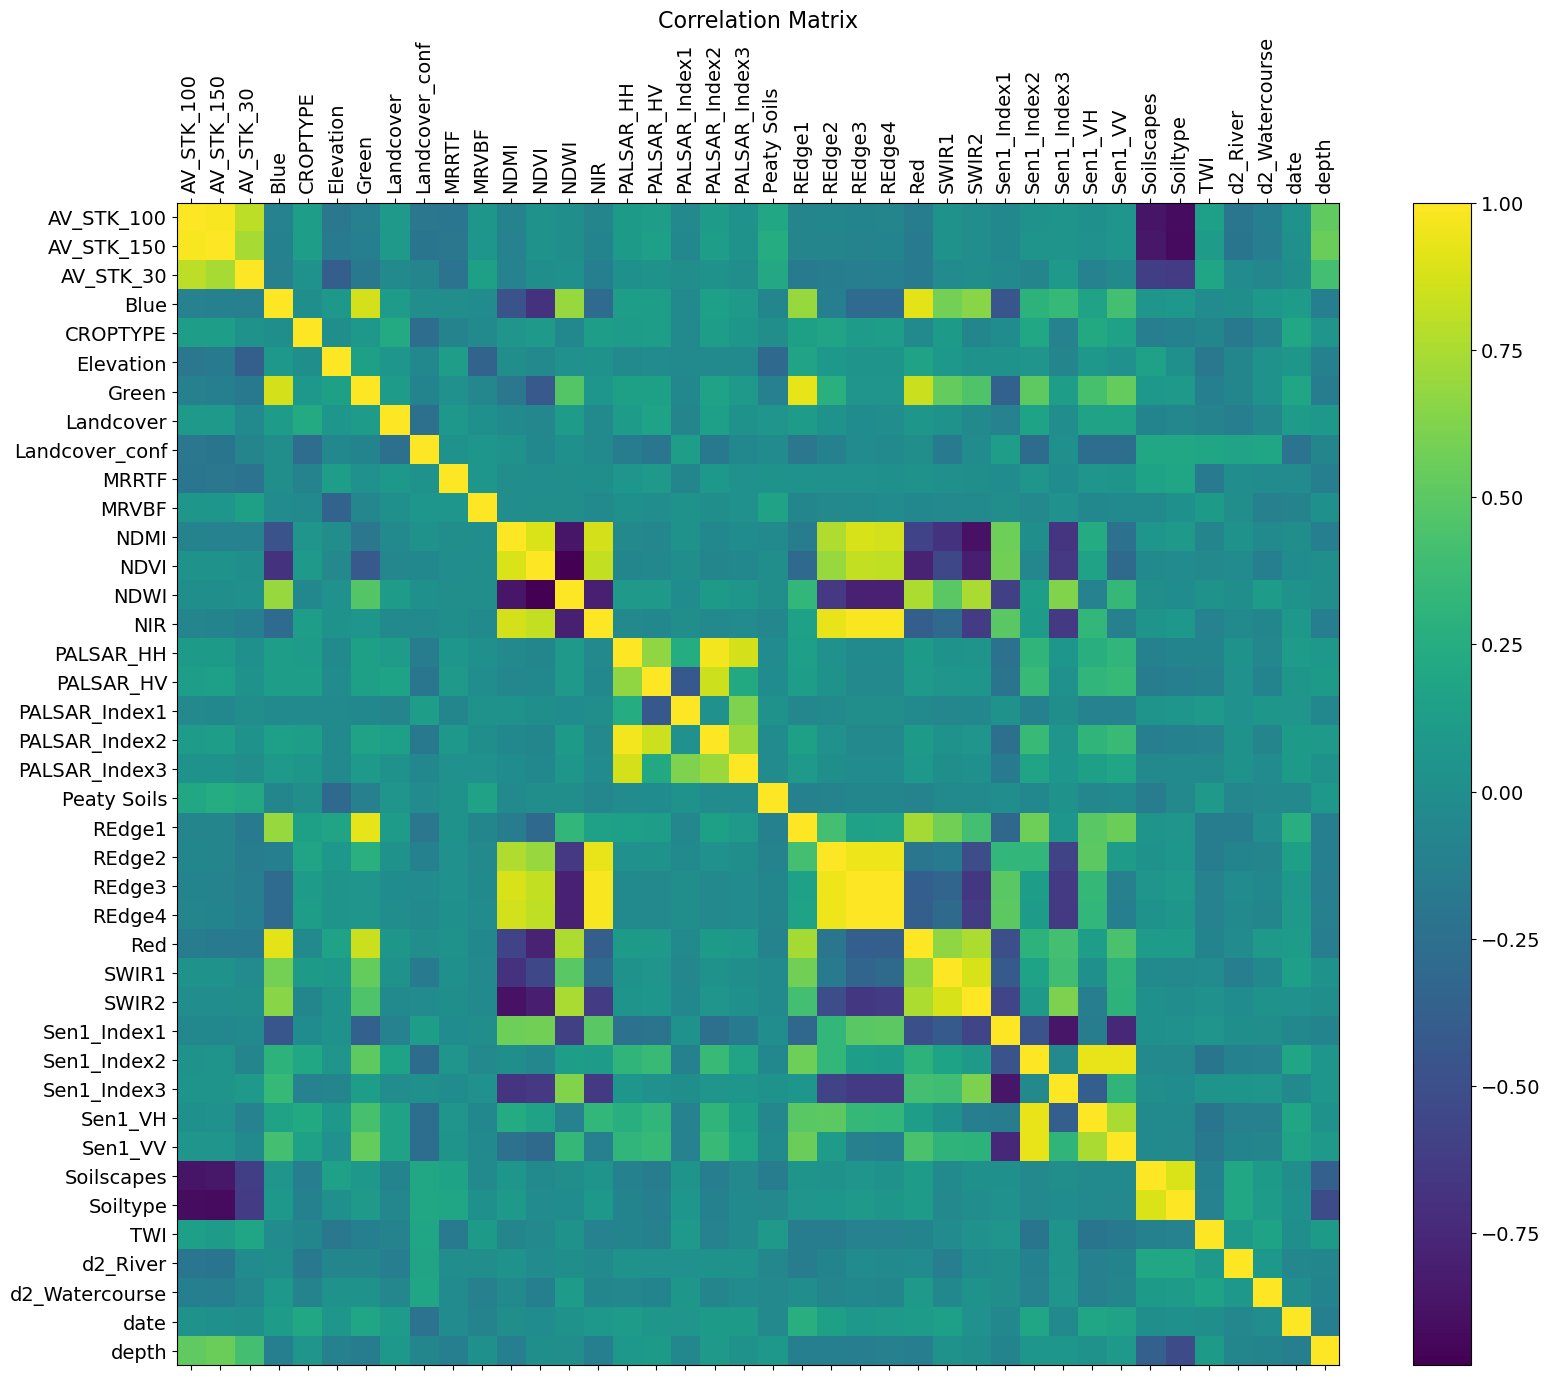

In [10]:
# plot the correlation matrix between all the predictors 
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

# Random Forest

In [59]:
# instantiate the random forest regressor object
rf_model = RandomForestRegressor(n_estimators = 100, random_state = 1, oob_score=True)
 
# fit the random forest to the x and y data (for random forest don't need validation set)
rf_model.fit(pd.concat([x_train, x_val]), pd.concat([y_train, y_val])) 

RandomForestRegressor(oob_score=True, random_state=1)

In [60]:
# look at the feature importances for the model
importances = rf_model.feature_importances_

# place them in a pandas object and re-organise them
forest_importances = pd.Series(importances, index=feature_names)
forest_importances = forest_importances.sort_values().iloc[::-1]

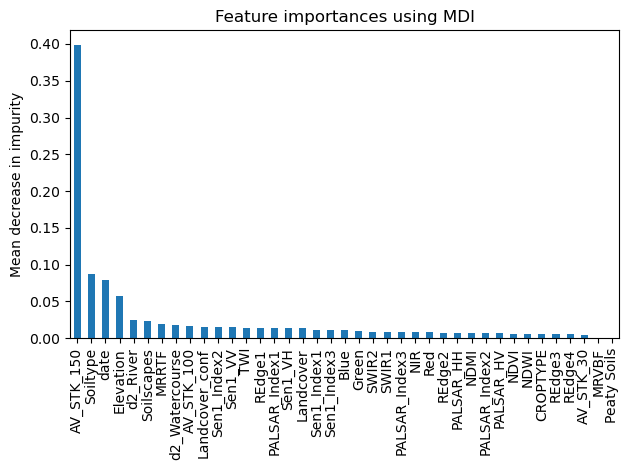

In [61]:
# plot the feature importances 
fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [62]:
y_pred_train_val = rf_model.predict(pd.concat([x_train, x_val]))
y_pred_test = rf_model.predict(x_test)

In [63]:
# Out of bag error is the average error given by trees on datapoints not used to train those trees? score?
print("Out of bag error:")
print(rf_model.oob_score_)

Out of bag error:
0.6256733644823018


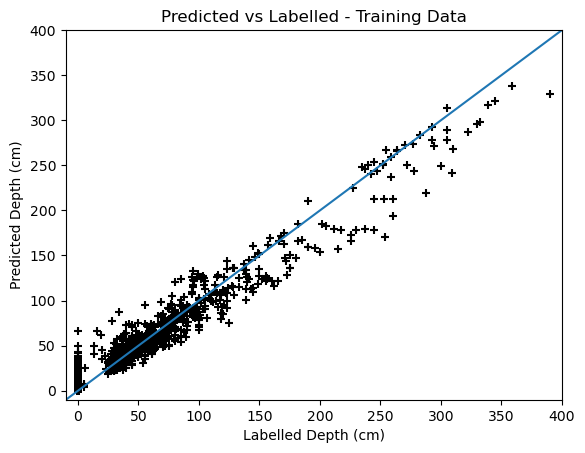

In [16]:
# add a scatter plot of the data points
plt.scatter(pd.concat([y_train, y_val]), y_pred_train_val, c='black', marker='+');
plt.xlabel("Labelled Depth (cm)")
plt.ylabel("Predicted Depth (cm)")
plt.title("Predicted vs Labelled - Training Data");
ax = plt.gca()
ax.set_ylim([-10, 400]);
ax.set_xlim([-10, 400]);

# add a y=x line
plt.plot([-10, 400], [-10, 400]);

In [41]:
# calculate the R-Squared and RMSE error to model evaluation
true_values = pd.concat([y_train, y_val])
predictions = y_pred_train_val

R_squared = r2_score(true_values, predictions)
print("R Squared:", R_squared)

RMSE = mean_squared_error(pd.concat([y_train, y_val]), y_pred_train_val, squared=False)
print("RMSE:", RMSE)

R Squared: 0.9483203338371973
RMSE: 14.947507279274399
R Squared (excluding zero points): 0.9282471479107494


R Squared (excluding zero points): 0.9282471479107494
RMSE: 18.31978036931542


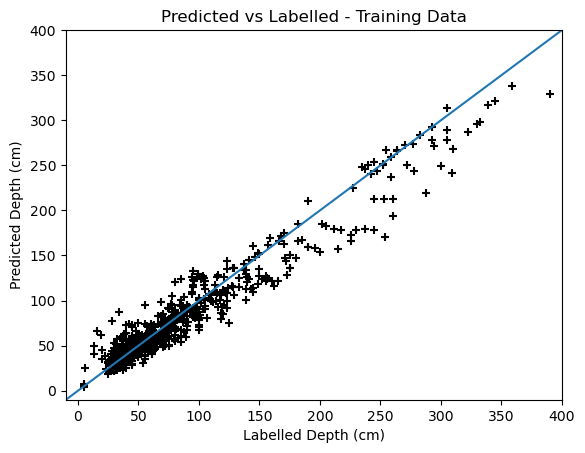

In [46]:
# half the truth labels in the training set are = 0! 
plt.scatter(true_values[true_values!=0],predictions[true_values!=0], c='black', marker='+');
plt.xlabel("Labelled Depth (cm)")
plt.ylabel("Predicted Depth (cm)")
plt.title("Predicted vs Labelled - Training Data");
ax = plt.gca()
ax.set_ylim([-10, 400]);
ax.set_xlim([-10, 400]);

# add a y=x line
plt.plot([-10, 400], [-10, 400]);

R_squared = r2_score(true_values[true_values!=0], predictions[true_values!=0])
print("R Squared (excluding zero points):", R_squared)

RMSE = mean_squared_error(true_values[true_values!=0], predictions[true_values!=0], squared=False)
print("RMSE:", RMSE)

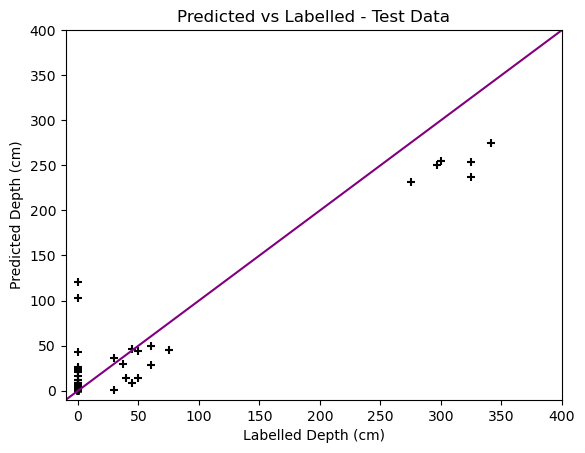

In [18]:
# add a scatter plot of the data points
plt.scatter(y_test, y_pred_test, c='black', marker='+');
plt.xlabel("Labelled Depth (cm)")
plt.ylabel("Predicted Depth (cm)")
plt.title("Predicted vs Labelled - Test Data");
ax = plt.gca()
ax.set_ylim([-10, 400]);
ax.set_xlim([-10, 400]);

# add a y=x line
plt.plot([-10, 400], [-10, 400], c='purple');

In [19]:
# calculate the R-Squared and RMSE error to model evaluation
R_squared = r2_score(y_test, y_pred_test)
print("R Squared:", R_squared)

RMSE = mean_squared_error(y_test, y_pred_test, squared=False)
print("RMSE:", RMSE)

R Squared: 0.8900033590756515
RMSE: 24.959468215654102


In [20]:
# study the partial dependence between the predicted thickness and predictors 
#from sklearn.inspection import PartialDependenceDisplay
#PartialDependenceDisplay.from_estimator(rf_model, x_train, ['AV_STK_100'])

# Gradient Boosting Machine 

In [21]:
df

,AV_STK_100,AV_STK_150,AV_STK_30,Blue,CROPTYPE,Elevation,Green,Landcover,Landcover_conf,MRRTF,...,Sen1_Index3,Sen1_VH,Sen1_VV,Soilscapes,Soiltype,TWI,d2_River,d2_Watercourse,date,depth
system:index,,,,,,,,,,,,,,,,,,,,,
0,9.260000,5.490000,10.420000,653.666667,1,2.65525,902.000000,3,94,4,...,6.967378,-21.588568,-14.621190,8,46,15.141784,818.413086,30.000000,1980,0
1,9.260000,5.490000,10.420000,582.500000,16,2.31175,801.000000,3,98,4,...,6.516706,-19.182083,-12.665377,8,46,12.653238,197.989899,36.055511,1980,0
2,66.599998,36.169998,33.459999,525.000000,16,1.16625,682.000000,21,54,4,...,7.014743,-20.876295,-13.861552,0,4,13.789957,509.215088,20.000000,1985,41
3,66.599998,36.169998,33.459999,543.333333,2,1.28775,743.666667,3,97,3,...,7.555333,-20.863428,-13.308095,0,4,13.953518,660.984131,60.827629,1980,55
4,66.599998,36.169998,33.459999,548.333333,2,1.70425,741.333333,3,89,3,...,7.973936,-19.612972,-11.639036,0,4,14.691748,652.533508,0.000000,1985,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983,27.400000,13.140000,19.549999,291.125000,29,1.46500,398.250000,3,85,5,...,6.605074,-16.067210,-9.462136,9,53,14.287312,256.124969,31.622776,2021,0
818,27.110001,11.070000,28.070000,496.000000,18,-1.73500,1028.076923,3,99,2,...,5.723408,-14.091508,-8.368101,9,51,14.473495,2080.216309,20.000000,2021,0
514,27.400000,13.140000,19.549999,733.222222,12,0.07000,966.888889,3,75,6,...,7.314945,-22.406925,-15.091980,9,53,13.300021,548.178772,141.421356,2021,0


# Neural Net (fastai)

In [22]:
# May need some initial pre-processing steps here e.g. log transforms 

In [20]:
# get data ready for training by specifying what Tabular data loader needs to know 
#   df = dataframe working with
#   splits = indexs used for training and testing
#   procs = pre-processing steps (we don't use categorify and fill missing since already proceessed)
#   cat_names = names of categorical data columns
#   cont_names = names of columns with continuous data
#   y_names = label column name
#   y_block = either CategoryBlock or RegressionBlock depending on target type
dls = TabularPandas(
    df, 
    splits=splits_train_val,
    procs = [Categorify, Normalize],
    cat_names=["CROPTYPE", "Landcover", "MRRTF", "MRVBF", "Soilscapes", "Soiltype",],
    cont_names=['AV_STK_100', 'AV_STK_150', 'AV_STK_30', 'Blue', 'Elevation', 'Green', 'NDMI', 'NDVI', 'NDWI', 'NIR',
                'PALSAR_HH', 'PALSAR_HV', 'PALSAR_Index1', 'PALSAR_Index2', 'PALSAR_Index3', 'REdge1', 'REdge2', 
                'REdge3', 'REdge4', 'Red', 'SWIR1', 'SWIR2', 'Sen1_Index1', 'Sen1_Index2', 'Sen1_Index3', 'Sen1_VH', 
                'Sen1_VV', 'TWI', 'd2_River', 'd2_Watercourse', 'Landcover_conf', 'date'],
    y_names="depth", 
    y_block = RegressionBlock(),
).dataloaders(path=".")

In [21]:
# Build a learner (model + data)
# we specify the size of each HIDDEN layer (doesn't matter how many inputs we have or outputs, just the main body of model)
learn = tabular_learner(dls, metrics=[rmse, R2Score()], layers=[200,100])

In [22]:
# we never want negative preidictions so add a ReLU to the final layer
learn.model.layers.add_module("ReLU", nn.ReLU(inplace=True))

In [23]:
# to see the exact architecture that fastai specifies when using the TabularLearner function we call learn.model
# we use embeddings, dropout, batchnorm and 2 hidden layers in our network
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(25, 10)
    (1): Embedding(9, 5)
    (2): Embedding(8, 5)
    (3): Embedding(8, 5)
    (4): Embedding(12, 6)
    (5): Embedding(25, 10)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=73, out_features=200, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=200, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=1, bias=True)
    )
    (ReLU): ReLU(inplace=True)
  )
)

In [24]:
#learn.lr_find(suggest_funcs=(slide, valley))

In [25]:
# I'm guessing we need a large learning rate since we have so many features that travessing the space of optimal weights
# takes a long time. When we have done feature selection this won't be so much of a problem
learn.fit(25, lr=0.1)
learn.fit(15, lr=0.01)

epoch,train_loss,valid_loss,_rmse,r2_score,time
0,4052.676758,3068.716797,55.396000,0.304011,00:00
1,3011.211914,2064.979492,45.442047,0.531660,00:00
2,2603.466064,2191.357422,46.811935,0.502997,00:00
3,2264.564697,2015.687256,44.896404,0.542840,00:00
4,2059.319336,1761.085571,41.965290,0.600584,00:00
5,1920.346558,1755.449585,41.898087,0.601862,00:00
6,1791.375000,1973.148926,44.420143,0.552487,00:00
7,1686.616943,1923.367432,43.856216,0.563778,00:00
8,1624.759155,1693.646362,41.153934,0.615879,00:00
9,1559.773560,1776.886108,42.153130,0.597000,00:00


epoch,train_loss,valid_loss,_rmse,r2_score,time
0,629.799500,1611.554932,40.144176,0.634497,00:00
1,614.998474,1720.500732,41.478916,0.609788,00:00
2,629.055542,1717.220703,41.439362,0.610532,00:00
3,590.069397,1737.041016,41.677826,0.606037,00:00
4,561.724182,1765.247925,42.014854,0.599640,00:00
5,537.543945,1810.235107,42.546856,0.589436,00:00
6,523.953918,1870.065430,43.244255,0.575867,00:00
7,508.627136,1849.155884,43.001812,0.580609,00:00
8,477.235596,1942.545166,44.074314,0.559428,00:00
9,448.384277,1890.460327,43.479424,0.571241,00:00


R Squared: 0.9372211609459312
RMSE: 16.411482130510365


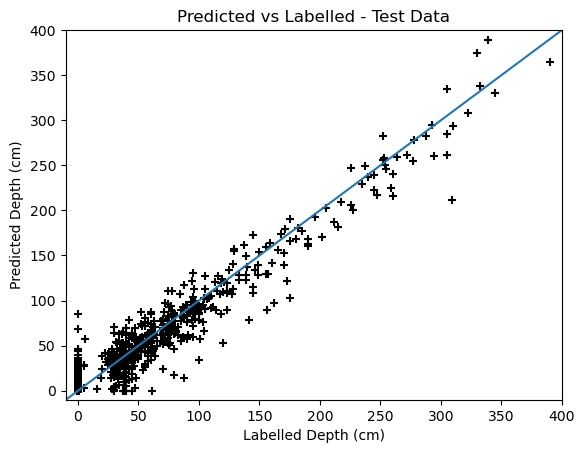

In [52]:
# Use the trained model to get predictions for training dataset
preds_train,_ = learn.get_preds(dl=dls.train)

# plot the predictions and calculate the rmse and R2 score 
plt.scatter(y_train, preds_train, c='black', marker='+');
plt.xlabel("Labelled Depth (cm)")
plt.ylabel("Predicted Depth (cm)")
plt.title("Predicted vs Labelled - Test Data");
ax = plt.gca()
ax.set_ylim([-10, 400]);
ax.set_xlim([-10, 400]);

# add a y=x line
plt.plot([-10, 400], [-10, 400]);

# calculate the R-Squared and RMSE error to model evaluation
R_squared = r2_score(y_train, preds_train)
print("R Squared:", R_squared)

RMSE = mean_squared_error(y_train, preds_train, squared=False)
print("RMSE:", RMSE)

R Squared: 0.5704430344435583
RMSE: 43.51987848899505


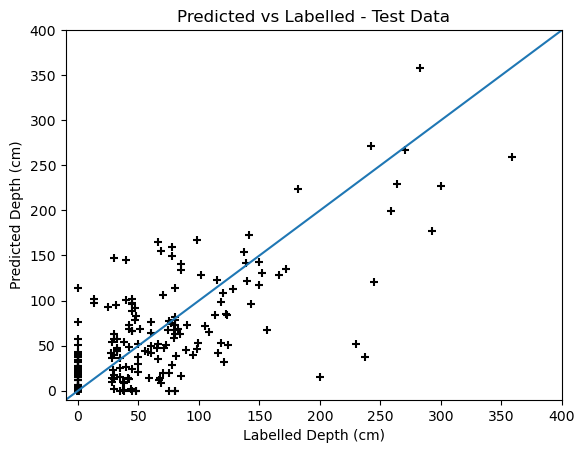

In [53]:
# Use the trained model to get predictions for training dataset
preds_val,_ = learn.get_preds(dl=dls.valid)

# plot the predictions and calculate the rmse and R2 score 
plt.scatter(y_val, preds_val, c='black', marker='+');
plt.xlabel("Labelled Depth (cm)")
plt.ylabel("Predicted Depth (cm)")
plt.title("Predicted vs Labelled - Test Data");
ax = plt.gca()
ax.set_ylim([-10, 400]);
ax.set_xlim([-10, 400]);

# add a y=x line
plt.plot([-10, 400], [-10, 400]);

# calculate the R-Squared and RMSE error to model evaluation
R_squared = r2_score(y_val, preds_val)
print("R Squared:", R_squared)

RMSE = mean_squared_error(y_val, preds_val, squared=False)
print("RMSE:", RMSE)

In [27]:
# test performance on the holdout dataset

# make sure to do same feature-engineering steps to the test dataset (processing steps stored in learner but want to
# apply to a new dataset so just grab a test_dl object with same transforms stored)
tst_dl = learn.dls.test_dl(test_df)

In [28]:
# get predictions from data loaded in in the correct way
preds,_ = learn.get_preds(dl=tst_dl)

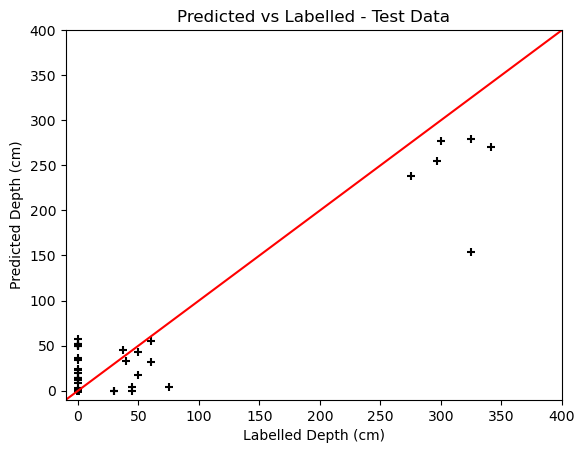

In [29]:
# plot the predictions and calculate the rmse and R2 score 
plt.scatter(y_test, preds, c='black', marker='+');
plt.xlabel("Labelled Depth (cm)")
plt.ylabel("Predicted Depth (cm)")
plt.title("Predicted vs Labelled - Test Data");
ax = plt.gca()
ax.set_ylim([-10, 400]);
ax.set_xlim([-10, 400]);

# add a y=x line
plt.plot([-10, 400], [-10, 400], c='red');

In [37]:
# calculate the R-Squared and RMSE error to model evaluation
R_squared = r2_score(y_test, preds)
print("R Squared:", R_squared)

RMSE = mean_squared_error(y_test, preds, squared=False)
print("RMSE:", RMSE)

R Squared: 0.8665135331748337
RMSE: 27.495665497511098


# Ensembling

In [34]:
# Simplest kind of ensembling is ensembling same kind of model but trained of different subsets of data
# Essentially make a model, fit the model, predict on test set and return predictions 

def ensemble():
    learn = tabular_learner(dls, metrics=[rmse, R2Score()], layers=[10,10])
    with learn.no_bar(),learn.no_logging(): learn.fit(25, lr=0.1)
    with learn.no_bar(),learn.no_logging(): learn.fit(10, lr=0.01)    
    return learn.get_preds(dl=tst_dl)[0]

In [35]:
# do this 5 times and store all predictions 
learns = [ensemble() for _ in range(5)]

In [36]:
ens_preds = torch.stack(learns).mean(0)

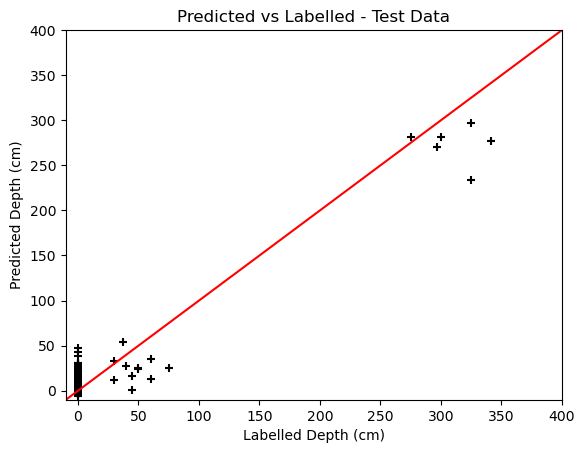

In [37]:
# plot the predictions and calculate the rmse and R2 score 
plt.scatter(y_test, ens_preds, c='black', marker='+');
plt.xlabel("Labelled Depth (cm)")
plt.ylabel("Predicted Depth (cm)")
plt.title("Predicted vs Labelled - Test Data");
ax = plt.gca()
ax.set_ylim([-10, 400]);
ax.set_xlim([-10, 400]);

# add a y=x line
plt.plot([-10, 400], [-10, 400], c='red');

In [38]:
# calculate the R-Squared and RMSE error to model evaluation
R_squared = r2_score(y_test, ens_preds)
print("R Squared:", R_squared)

RMSE = mean_squared_error(y_test, ens_preds, squared=False)
print("RMSE:", RMSE)

R Squared: 0.9198863435381218
RMSE: 21.300946104363742


# Embeddings of categories 

We also want to try using embeddings as inputs to the random forests instead of only relying on the assumed numerical relationship bteween categories. Therefor we need a method for generating embeddings of the categorical variables, and then use these to make a new dataframe with the new relevant columns. 

In [39]:
# we can grab the fitted embeddings from the model that has already been trained (this trains parameters of embedding
# matrix for us)
# We only need to grab the embeddings of the features we actually want to use after our feature selection process 
MRRTF_embedding = learn.model.embeds[2]

Find the embeddings for every row in the train/val dataframe. Make a new dataframe with these embedding vectors appended to the dataframe

In [40]:
# for each row in dataframe we need to find the value of MRRTF and use this to get the equivalent 
# embedding which should then be added to the dataframe 
mrrtf_data = torch.LongTensor(df['MRRTF'].values)
embedding_vectors = MRRTF_embedding.forward(mrrtf_data).detach()

# make this into a pandas dataframe so that we can join later 
embedding_vectors_df = pd.DataFrame(embedding_vectors.numpy(), index=df.index)
embedding_vectors_df.columns = ['MRRTF_E1', 'MRRTF_E2', 'MRRTF_E3', 'MRRTF_E4', 'MRRTF_E5']

# join the original dataframe with the required embeddings 
df_embed = pd.concat([df, embedding_vectors_df], axis=1)

Need to do the same process to the test dataframe also

In [41]:
mrrtf_data = torch.LongTensor(test_df['MRRTF'].values)
embedding_vectors = MRRTF_embedding.forward(mrrtf_data).detach()

# make this into a pandas dataframe so that we can join later 
embedding_vectors_df = pd.DataFrame(embedding_vectors.numpy(), index=test_df.index)
embedding_vectors_df.columns = ['MRRTF_E1', 'MRRTF_E2', 'MRRTF_E3', 'MRRTF_E4', 'MRRTF_E5']

# join the original dataframe with the required embeddings 
test_df_embed = pd.concat([test_df, embedding_vectors_df], axis=1)

Split the data into the explicit sub-splits that we need for modelling 

In [42]:
# for some models we need explicit datasets
x_train_embed = df_embed.iloc[splits_train_val[0],:].drop('depth', axis=1)
y_train_embed = df_embed.iloc[splits_train_val[0],:]['depth']

x_val_embed = df_embed.iloc[splits_train_val[1],:].drop('depth', axis=1)
y_val_embed = df_embed.iloc[splits_train_val[1],:]['depth']

# some models need explicit datasets
x_test_embed = test_df_embed.drop('depth', axis=1)
y_test_embed = test_df_embed['depth']

In [43]:
# check performance of random forest as a result
rf_model = RandomForestRegressor(n_estimators = 100, random_state = 0, oob_score=True)
 
# fit the random forest to the x and y data (for random forest don't need validation set)
rf_model.fit(pd.concat([x_train_embed, x_val_embed]), pd.concat([y_train_embed, y_val_embed])) 

RandomForestRegressor(oob_score=True, random_state=0)

In [44]:
# get the feature names from the column headings 
feature_names = [i for i in df_embed.columns]
feature_names.remove('depth')

# look at the feature importances for the model
importances = rf_model.feature_importances_

# place them in a pandas object and re-organise them
forest_importances = pd.Series(importances, index=feature_names)
forest_importances = forest_importances.sort_values().iloc[::-1]

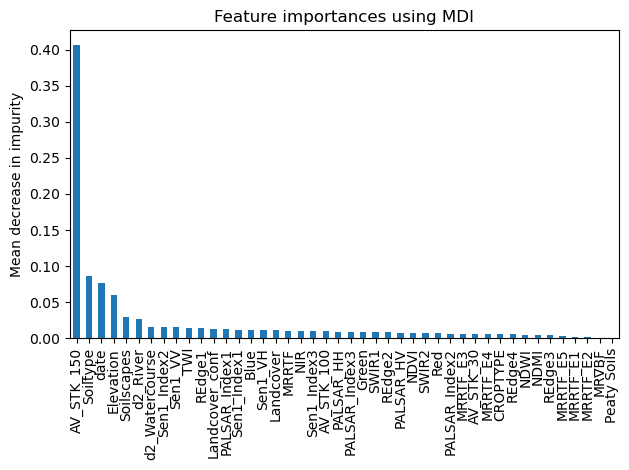

In [45]:
# plot the feature importances 
fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [46]:
y_pred_train_val = rf_model.predict(pd.concat([x_train_embed, x_val_embed]))
y_pred_test = rf_model.predict(x_test_embed)

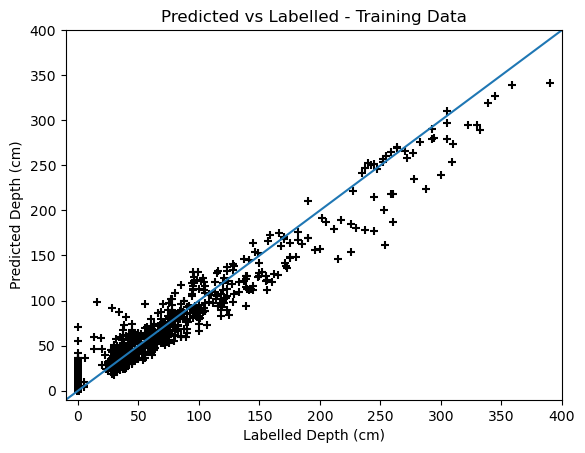

In [47]:
# add a scatter plot of the data points
plt.scatter(pd.concat([y_train_embed, y_val_embed]), y_pred_train_val, c='black', marker='+');
plt.xlabel("Labelled Depth (cm)")
plt.ylabel("Predicted Depth (cm)")
plt.title("Predicted vs Labelled - Training Data");
ax = plt.gca()
ax.set_ylim([-10, 400]);
ax.set_xlim([-10, 400]);

# add a y=x line
plt.plot([-10, 400], [-10, 400]);

In [48]:
# calculate the R-Squared and RMSE error to model evaluation
R_squared = r2_score(pd.concat([y_train_embed, y_val_embed]), y_pred_train_val)
print("R Squared:", R_squared)

RMSE = mean_squared_error(pd.concat([y_train_embed, y_val_embed]), y_pred_train_val, squared=False)
print("RMSE:", RMSE)

R Squared: 0.9474703528989208
RMSE: 15.069927584229397


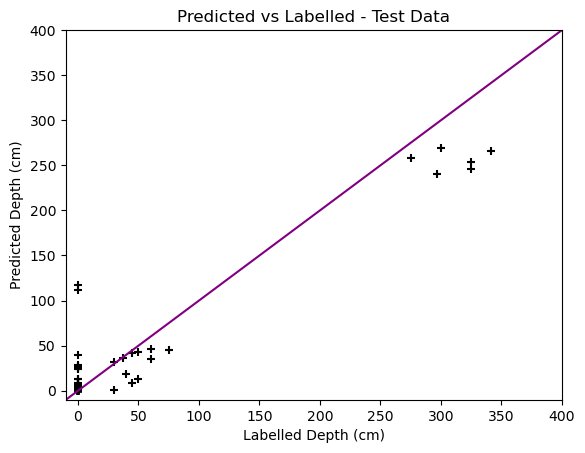

In [49]:
# add a scatter plot of the data points
plt.scatter(y_test_embed, y_pred_test, c='black', marker='+');
plt.xlabel("Labelled Depth (cm)")
plt.ylabel("Predicted Depth (cm)")
plt.title("Predicted vs Labelled - Test Data");
ax = plt.gca()
ax.set_ylim([-10, 400]);
ax.set_xlim([-10, 400]);

# add a y=x line
plt.plot([-10, 400], [-10, 400], c='purple');

In [50]:
# calculate the R-Squared and RMSE error to model evaluation
R_squared = r2_score(y_test_embed, y_pred_test)
print("R Squared:", R_squared)

RMSE = mean_squared_error(y_test_embed, y_pred_test, squared=False)
print("RMSE:", RMSE)

R Squared: 0.892064365213394
RMSE: 24.724529828850777
